In [9]:
import numpy as np
from HestonFunctions_copy import Heston_explicit_bf, HestonCallClosedForm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import bisect
from math import isnan
from scipy.optimize import brentq
from scipy.stats import norm

In [2]:
#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag, np.exp(-r*T), np.exp((r-d)*T)*S, X, T, v)

In [3]:
def heston_Impliedvol(heston_price,r,T,s0,K):
    myPrice = heston_price
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    root  = bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)
    return root


In [10]:
def bs_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    else:
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return price

# Implied volatility function
def implied_volatility(S, K, T, r, market_price, option_type='call'):
    def iv_objective(sigma):
        # This is the objective function: the difference between the market price and the BS model price
        return bs_price(S, K, T, r, sigma, option_type) - market_price

    # Initial guess for sigma
    sigma_guess = 0.2
    try:
        # Brent's method to find the root of the objective function
        implied_vol = brentq(iv_objective, a=1e-6, b=3) #x0=sigma_guess)
    except ValueError:
        # If the Brent method fails, it often means that no solution was found within the bounds
        # It could be due to market prices being outside no-arbitrage bounds, or other numerical issues
        implied_vol = np.nan

    return implied_vol

In [4]:
# Using Heston_explicit_bf to find option prices
kappa=2
eta=0.2
sigma=0.3
rho=0.8
V0=1
r=0.03
T=1
dt=1/7000
S0=200
I=40
J=20
K=100

U_heston, _ = Heston_explicit_bf(kappa, eta, sigma, rho, V0, r, T, dt, S0, I, J, K)

100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps donee   100 steps 

In [13]:
# Calculate implied volatilities across the range of strikes and maturities
strikes = np.arange(80, 121, 1) # Your range of strikes
maturities = np.arange(0, 1, 1/21)  # Your range of maturities
S0 = 200  # Current stock price
r = 0.03  # Risk-free rate

# Initialize an empty matrix for the implied volatilities
iv_matrix = np.zeros_like(U_heston)

# Populate the implied volatility matrix
for i, strike in enumerate(strikes):
    for j, maturity in enumerate(maturities):
        market_price = HestonCallClosedForm(kappa, eta, sigma, rho, V0, r, T, S0, K)
        iv_matrix[i, j] = implied_volatility(S0, strike, maturity, r, market_price, option_type='call')

C:\Users\IshaG\AppData\Local\Temp\ipykernel_27972\3511440034.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


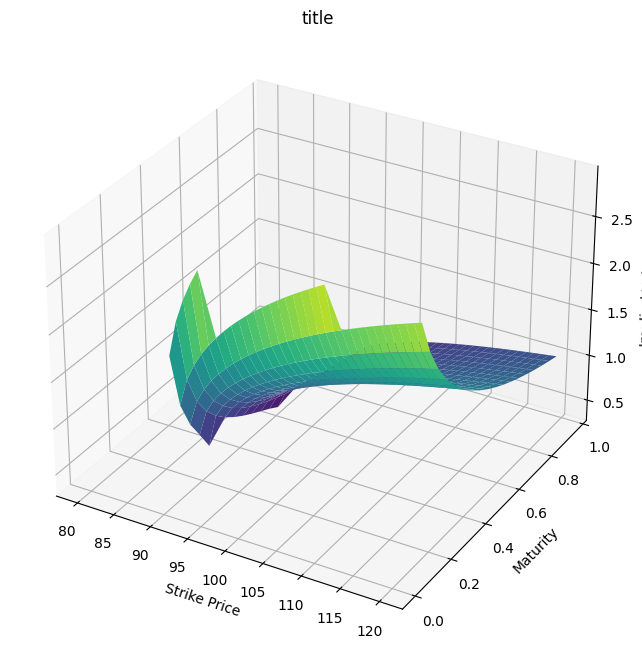

In [14]:
# plot the implied volatility surface

X, Y = np.meshgrid(strikes, maturities)
Z = iv_matrix.T  # Transpose the matrix to align with the meshgrid orientation

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add title and labels
ax.set_title("title")
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')

# Add a color bar to show the scale of implied volatility
# fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()

In [16]:
from scipy.optimize import newton
import math

def BlackScholesCall(S0, K, tau, r, sigma, EPS=0.01):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    
    if tau < EPS:
        return max(S0 - K, 0)
    else:
        return S0 * norm.cdf(d1) - K * math.exp(-r * tau) * norm.cdf(d2)


def ImpliedVolCall(S0, K, tau, r, Heston_price):
    def f(x):
        return BlackScholesCall(S0, K, tau, r, x) - Heston_price

    if f(-1) * f(1) > 0:
        return None

    # result = opt.root_scalar(f, bracket=[-1, 1], method='brentq')
    # return result.root

    initial_guess = 0.2
    try:
        iv = newton(f, initial_guess)
        return iv
    except RuntimeError:
        return np.nan

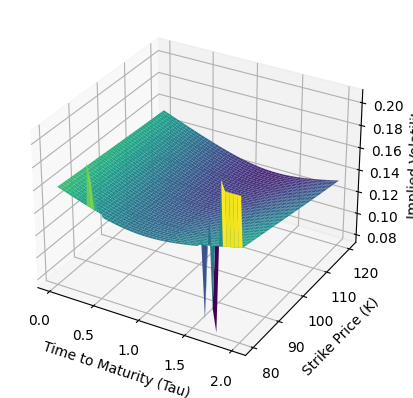

In [37]:
tau_range = np.linspace(0.01, 2, 50)  # Time to maturity in years
K_range = np.linspace(80, 120, 50)  # Strike prices range
X, Y = np.meshgrid(tau_range, K_range)
# Z = np.full((len(K_range), len(tau_range)), np.nan)
Z = np.zeros_like(X)

kappa=0.1
eta=0.02
sigma=0.2
rho=0
V0=0.02
r=0.03
T=10
S0=100


for i in range(len(tau_range)):
    for j in range(len(K_range)):
        tau = tau_range[i]
        K = K_range[j]
        # Assuming HestonCallClosedForm and ImpliedVolCall are predefined functions
        price = HestonCallClosedForm(kappa, eta, sigma, rho, V0, r, tau, S0, K)
        implied_vol = ImpliedVolCall(S0, K, tau, r, price)
        Z[i, j] = implied_vol if implied_vol is not None else np.nan

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# The plot_surface function should use X, Y, Z in the correct order
ax.plot_surface(X, Y, Z, cmap='viridis')

# Correct labels
ax.set_xlabel('Time to Maturity (Tau)')
ax.set_ylabel('Strike Price (K)')
ax.set_zlabel('Implied Volatility')

plt.show()

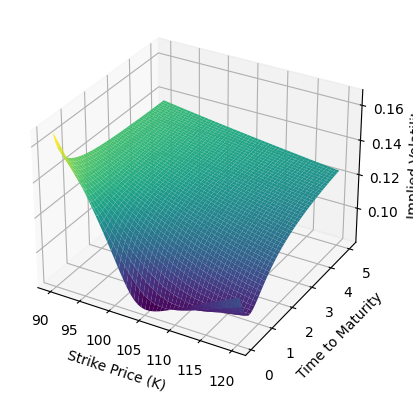

In [31]:
def plot_implied_volatility(lambda_, vbar, eta, rho, v0, r, S0, tau_range, K_range):
    X, Y = np.meshgrid(tau_range, K_range)
    Z = np.zeros_like(X)

    for i in range(len(tau_range)):
        for j in range(len(K_range)):
            tau = tau_range[i]
            K = K_range[j]
            price = HestonCallClosedForm(lambda_, vbar, eta, rho, v0, r, tau, S0, K)
            implied_vol = ImpliedVolCall(S0, K, tau, r, price)
            if implied_vol is not None:
                Z[j, i] = implied_vol
            else:
                Z[j, i] = np.nan

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Y, X, Z, cmap='viridis')

    ax.set_ylabel('Time to Maturity')
    ax.set_xlabel('Strike Price (K)')
    ax.set_zlabel('Implied Volatility')
    # ax.invert_xaxis()

    plt.show()

tau_range = np.linspace(0.1, 5, 50)  # Time to maturity in years
K_range = np.linspace(90, 120, 50)  # Strike prices range
lambda_ = 6.21
vbar = 0.019
eta = 0.61
rho = -0.7
v0 = 0.010201
r = 0
S0 = 100
plot_implied_volatility(lambda_, vbar, eta, rho, v0, r, S0, tau_range, K_range)

------------------------

In [15]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes formula for call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to find implied volatility
def implied_volatility(price, S, K, T, r):
    def f(sigma): return black_scholes_call(S, K, T, r, sigma) - price
    return brentq(f, 0.001, 2.0)

# Heston model parameters (example values)
params = {
    "kappa": 1.0,   # mean reversion speed
    "theta": 0.04,  # long-run volatility
    "sigma": 0.1,   # volatility of volatility
    "rho": -0.3,    # correlation between asset and volatility
    "v0": 0.04,     # initial volatility
    "r": 0.03,      # risk-free rate
    "T": 1.0,       # maturity
    "S0": 100,      # initial stock price
    "K": 100,       # strike price
}

# Simulate price paths using the Heston model (simplified example)
# In practice, you should use a more sophisticated method for simulation
np.random.seed(0)
N = 1000  # number of time steps
dt = params["T"] / N
v = np.zeros(N + 1)
s = np.zeros(N + 1)
v[0] = params["v0"]
s[0] = params["S0"]
for t in range(1, N + 1):
    z1 = np.random.normal()
    z2 = params["rho"] * z1 + np.sqrt(1 - params["rho"]**2) * np.random.normal()
    v[t] = np.maximum(v[t-1] + params["kappa"] * (params["theta"] - v[t-1]) * dt + params["sigma"] * np.sqrt(v[t-1]) * np.sqrt(dt) * z1, 0)
    s[t] = s[t-1] * np.exp((params["r"] - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * np.sqrt(dt) * z2)

# Calculate option price using simulated paths
option_price = np.mean(np.maximum(s[-1] - params["K"], 0) * np.exp(-params["r"] * params["T"]))

# Calculate implied volatility
iv = implied_volatility(option_price, params["S0"], params["K"], params["T"], params["r"])
print(f"Implied Volatility: {iv:.2f}")


Implied Volatility: 0.03
